## Assignment 1:

In this assignment, we construct **dense neural networks** for classifying images from the `MNIST` dataset: http://yann.lecun.com/exdb/mnist/. The MNIST database consists of a set of 70,000 small (28x28 pixel) grayscale images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

>In **EXPERIMENTS 1 to 3**, we consider `dense neural network` models with one hidden layer. We start with one node in this hidden layer and progressively increase the number of (hidden) nodes in the layer until we find the "best" model in Experiment 3.

 But our goal in these `three` experiments is *not only* to find the "best" `dense neural network` model with one hidden but *also* to explore what the node(s) in the hidden layer are "detecting" and what their outputs (i.e. `activation values`) contribute to the final classification of an image. These are examples of intrinsic `global explanations` and `local explanations` , respectively, as described in this recent survey article: 

https://cacm.acm.org/magazines/2020/1/241703-techniques-for-interpretable-machine-learning/fulltext

To determine what the hidden node is "detecting" we use gradient descent to find a visual pattern that maximizes the activation value of the hidden node, i.e. the visual pattern that the hidden node is maximally responsive to. In this case, the exercise is probably not very insightful. But in `Assignment 2`  we will repeat this analysis with "clusters of nodes" (`convnet filters`) in `convolutional neural network` models. By the examining the patterns that each convnet filter is maximally responsive (but also by visualizing the convnet activations for particular test images) we should be able to determine what (some of) the filters in the `CCN` model are up to. The (activation values of the) hidden nodes (actually, groups of hidden nodes corresponding or *convnet filters*) can be visualized in various ways to show what "features" (edges, texture, etc.) of the input images they capture.

>In **EXPERIMENT 4** we use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from `Experiment 3` to 154 inputs nodes and train it on the new lower dimensional data. 

>In **EXPERIMENT 5** we use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' `dense neural network` using these 70 features and compare its performance to the the `dense neural network` models from EXPERIMENTS 3 and 4.

Here are more details for the first `three` experiments:

* **EXPERIMENT 1**: Our `dense neural network` will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on `CNN` models in `Assignment 2`.

* **EXPERIMENT 2**: This time our `dense neural network` will have 784 input nodes, a hidden layer with `2 nodes` and 10 output nodes (corresponding to the 10 digits). For each of the 60,000 images, the output of the two hidden nodes are plotted using a `scatterplot`. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in `EXPERIMENT 1`, the color clusters should have very little overlap.

**NOTE**: For EXPERIMENTS 1 & 2 we also perform the following additional tasks:
> 1. We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.
> 2. For each model we obtain the confusion matrix and use it to display sample images of true vs false positives and negatives.


* **EXPERIMENT 3**: Students can experiment with more hidden nodes (in the hidden layer) to obtain the `best` model. This `final` model will be used in EXPERIMENTS 4 & 5.


**References**:
https://github.com/fchollet/deep-learning-with-python-notebooks (2.1 & 5.4)

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
tf.__version__

'2.1.0'

In [3]:
import numpy as np
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The MNIST dataset

The MNIST dataset of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It comes prepackaged as part of tf.Keras. Use the `mnist.load_data()` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [4]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# EXPERIMENT  3:

We want to select the *best* `DNN` model subject to some the following restriction on `hyperparameters`:
* The number of hidden layers will be one. 

We will use `sklearn.grid_search.GridSearchCV` to find the `best` number of neurons for the hidden layer.

As before we will need 784 input nodes and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [5]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## Validating our approach

Since we will be using categorical_crossentropy as the loss function we need to use to_categorical to convert the class vector of lables to binary matrix representation. 

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [6]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Fine-Tuning the Hyperparameters

We adapt the code from Chapter 10 of Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow by A. Geron:

https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

See also https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch10.html. 

We define a `build_model` function to create a `DNN` model with a given number of hidden layers and a fixed given number of nodes per hidden layer. (What if we wanted the number of nodes to vary by layer?)

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(n_hidden=1, n_neurons=2, learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

No that the `build_model` function creates a neural network with the same (*n_neurons*) number of nodes in each hidden layer. Here is the revised `build_model2` that takes a tuple `(n1,n2...)`, where the number of coordinates is the number of `hidden layers` with `n1` nodes in the first hidden layer, `n2` nodes in the second, etc.

In [8]:
def build_model2(n_neurons=(2,3), learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(len(n_neurons)):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

New we a create a `KerasClassifier` object, the class is an implementation of the scikit-learn classifier API for Keras. It is actually a thin wrapper around the model that is built using our `build_model` function.

In [9]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
keras_clf = KerasClassifier(build_model)

We first consider the performance from using 1 to 100 hidden nodes, i.e. we use the following grid parameters.

```python
param_grid = {'n_neurons': range(1,100)}
param_grid
```
and found that 20 hidden nodes provided the best model with a test accuracy of 95.99%. 

We also tried multiples of 100 from 100 up to 900. Running the test and found the 500 nodes gave the best result with an accuracy of 99.68%. We demonstrate this latter. 

In [10]:
param_grid = {'n_neurons': range(1,101)}
param_grid

{'n_neurons': range(1, 101)}

In [11]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(estimator=keras_clf, param_grid=param_grid,cv=3,verbose = 2)
grid_cv.fit(train_images, train_labels, epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_neurons=1 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 1s 39us/sample - loss: 2.0357 - accuracy: 0.2119 - val_loss: 1.9155 - val_accuracy: 0.2374
Epoch 2/30
36666/36666 [==============================] - 1s 31us/sample - loss: 1.8709 - accuracy: 0.2552 - val_loss: 1.8285 - val_accuracy: 0.2614
Epoch 3/30
36666/36666 [==============================] - 1s 31us/sample - loss: 1.8038 - accuracy: 0.2846 - val_loss: 1.7706 - val_accuracy: 0.2976
Epoch 4/30
36666/36666 [==============================] - 1s 30us/sample - loss: 1.7496 - accuracy: 0.3096 - val_loss: 1.7166 - val_accuracy: 0.3290
Epoch 5/30
36666/36666 [==============================] - 1s 35us/sample - loss: 1.7004 - accuracy: 0.3205 - val_loss: 1.6710 - val_accuracy: 0.3176
Epoch 6/30
36666/36666 [==============================] - 1s 32us/sample - loss: 1.6644 - accuracy: 0.3276 - val_loss: 1.6403 - val_accuracy: 0.3314
Epoch 7/30
36666/36666 [==============================] -

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.2s remaining:    0.0s


36667/36667 [==============================] - 1s 40us/sample - loss: 2.0274 - accuracy: 0.2141 - val_loss: 1.9179 - val_accuracy: 0.2356
Epoch 2/30
36667/36667 [==============================] - 1s 33us/sample - loss: 1.8757 - accuracy: 0.2549 - val_loss: 1.8207 - val_accuracy: 0.2808
Epoch 3/30
36667/36667 [==============================] - 1s 32us/sample - loss: 1.8066 - accuracy: 0.2759 - val_loss: 1.7689 - val_accuracy: 0.2936
Epoch 4/30
36667/36667 [==============================] - 1s 30us/sample - loss: 1.7666 - accuracy: 0.2886 - val_loss: 1.7396 - val_accuracy: 0.3000
Epoch 5/30
36667/36667 [==============================] - 1s 31us/sample - loss: 1.7387 - accuracy: 0.2971 - val_loss: 1.7179 - val_accuracy: 0.3174
Epoch 6/30
36667/36667 [==============================] - 1s 31us/sample - loss: 1.7161 - accuracy: 0.3108 - val_loss: 1.6956 - val_accuracy: 0.3264
Epoch 7/30
36667/36667 [==============================] - 1s 31us/sample - loss: 1.6953 - accuracy: 0.3256 - val_loss

Epoch 24/30
36667/36667 [==============================] - 1s 30us/sample - loss: 1.6099 - accuracy: 0.3559 - val_loss: 1.5978 - val_accuracy: 0.3528
Epoch 25/30
36667/36667 [==============================] - 1s 31us/sample - loss: 1.6083 - accuracy: 0.3560 - val_loss: 1.5939 - val_accuracy: 0.3432
Epoch 26/30
36667/36667 [==============================] - 1s 31us/sample - loss: 1.6070 - accuracy: 0.3575 - val_loss: 1.5959 - val_accuracy: 0.3456
Epoch 27/30
36667/36667 [==============================] - 1s 31us/sample - loss: 1.6053 - accuracy: 0.3561 - val_loss: 1.5931 - val_accuracy: 0.3538
Epoch 28/30
36667/36667 [==============================] - 1s 32us/sample - loss: 1.6048 - accuracy: 0.3566 - val_loss: 1.5948 - val_accuracy: 0.3660
Epoch 29/30
36667/36667 [==============================] - 1s 30us/sample - loss: 1.6033 - accuracy: 0.3593 - val_loss: 1.5868 - val_accuracy: 0.3630
Epoch 30/30
18333/18333 [==============================] - 0s 20us/sample - loss: 1.6180 - accuracy:

36667/36667 [==============================] - 1s 37us/sample - loss: 1.3292 - accuracy: 0.5229 - val_loss: 1.2680 - val_accuracy: 0.5388
Epoch 4/30
36667/36667 [==============================] - 2s 53us/sample - loss: 1.2616 - accuracy: 0.5435 - val_loss: 1.2204 - val_accuracy: 0.5472
Epoch 5/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.2246 - accuracy: 0.5511 - val_loss: 1.2015 - val_accuracy: 0.5512
Epoch 6/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.2027 - accuracy: 0.5592 - val_loss: 1.1791 - val_accuracy: 0.5644
Epoch 7/30
36667/36667 [==============================] - 1s 36us/sample - loss: 1.1864 - accuracy: 0.5709 - val_loss: 1.1739 - val_accuracy: 0.5706
Epoch 8/30
36667/36667 [==============================] - 1s 33us/sample - loss: 1.1728 - accuracy: 0.5802 - val_loss: 1.1581 - val_accuracy: 0.5872
Epoch 9/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.1588 - accuracy: 0.5919 - val_loss

Epoch 17/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.7055 - accuracy: 0.7733 - val_loss: 0.7055 - val_accuracy: 0.7910
Epoch 18/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.7024 - accuracy: 0.7748 - val_loss: 0.7086 - val_accuracy: 0.7876
Epoch 19/30
18333/18333 [==============================] - 1s 33us/sample - loss: 0.7361 - accuracy: 0.7686
[CV] ...................................... n_neurons=3, total=  31.3s
[CV] n_neurons=3 .....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 49us/sample - loss: 1.4306 - accuracy: 0.4996 - val_loss: 1.0043 - val_accuracy: 0.6796
Epoch 2/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.9444 - accuracy: 0.6962 - val_loss: 0.8291 - val_accuracy: 0.7378
Epoch 3/30
36667/36667 [==============================] - 1s 41us/sample - loss: 0.8433 - accuracy: 0.7

Epoch 2/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.7739 - accuracy: 0.7707 - val_loss: 0.6898 - val_accuracy: 0.8076
Epoch 3/30
36667/36667 [==============================] - 1s 31us/sample - loss: 0.6773 - accuracy: 0.8005 - val_loss: 0.6468 - val_accuracy: 0.8228
Epoch 4/30
36667/36667 [==============================] - 1s 31us/sample - loss: 0.6401 - accuracy: 0.8144 - val_loss: 0.6183 - val_accuracy: 0.8256
Epoch 5/30
36667/36667 [==============================] - 1s 31us/sample - loss: 0.6164 - accuracy: 0.8225 - val_loss: 0.6006 - val_accuracy: 0.8336
Epoch 6/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.5993 - accuracy: 0.8270 - val_loss: 0.5864 - val_accuracy: 0.8392
Epoch 7/30
36667/36667 [==============================] - 1s 31us/sample - loss: 0.5851 - accuracy: 0.8310 - val_loss: 0.5772 - val_accuracy: 0.8390
Epoch 8/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.5734 - accuracy: 0.8351

Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.0668 - accuracy: 0.6439 - val_loss: 0.6448 - val_accuracy: 0.8122
Epoch 2/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.5921 - accuracy: 0.8212 - val_loss: 0.5067 - val_accuracy: 0.8568
Epoch 3/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.5027 - accuracy: 0.8529 - val_loss: 0.4465 - val_accuracy: 0.8782
Epoch 4/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.4572 - accuracy: 0.8676 - val_loss: 0.4171 - val_accuracy: 0.8856
Epoch 5/30
36667/36667 [==============================] - 1s 31us/sample - loss: 0.4323 - accuracy: 0.8769 - val_loss: 0.4034 - val_accuracy: 0.8894
Epoch 6/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.4172 - accuracy: 0.8819 - val_loss: 0.3962 - val_accuracy: 0.8884
Epoch 7/30
36667/36667 [==============================] -

Epoch 5/30
36667/36667 [==============================] - 1s 32us/sample - loss: 0.3756 - accuracy: 0.8933 - val_loss: 0.3536 - val_accuracy: 0.9022
Epoch 6/30
36667/36667 [==============================] - 1s 33us/sample - loss: 0.3592 - accuracy: 0.8983 - val_loss: 0.3446 - val_accuracy: 0.9000
Epoch 7/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.3475 - accuracy: 0.9022 - val_loss: 0.3280 - val_accuracy: 0.9058
Epoch 8/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.3385 - accuracy: 0.9051 - val_loss: 0.3282 - val_accuracy: 0.9052
Epoch 9/30
36667/36667 [==============================] - 1s 33us/sample - loss: 0.3317 - accuracy: 0.9066 - val_loss: 0.3202 - val_accuracy: 0.9090
Epoch 10/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.3256 - accuracy: 0.9093 - val_loss: 0.3188 - val_accuracy: 0.9098
Epoch 11/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3215 - accuracy: 0.90

36667/36667 [==============================] - 1s 37us/sample - loss: 0.2952 - accuracy: 0.9182 - val_loss: 0.2883 - val_accuracy: 0.9212
Epoch 5/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.2843 - accuracy: 0.9215 - val_loss: 0.2872 - val_accuracy: 0.9220
Epoch 6/30
36667/36667 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.92 - 1s 39us/sample - loss: 0.2769 - accuracy: 0.9246 - val_loss: 0.2843 - val_accuracy: 0.9216
Epoch 7/30
36667/36667 [==============================] - 1s 41us/sample - loss: 0.2709 - accuracy: 0.9260 - val_loss: 0.2821 - val_accuracy: 0.9216
Epoch 8/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.2656 - accuracy: 0.9280 - val_loss: 0.2884 - val_accuracy: 0.9210
Epoch 9/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.3134 - accuracy: 0.9177
[CV] ...................................... n_neurons=9, total=  13.8s
[CV] n_neurons=9 .............................

Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.5785 - accuracy: 0.8375 - val_loss: 0.3131 - val_accuracy: 0.9134
Epoch 2/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.3123 - accuracy: 0.9115 - val_loss: 0.2797 - val_accuracy: 0.9216
Epoch 3/30
36666/36666 [==============================] - 1s 33us/sample - loss: 0.2841 - accuracy: 0.9180 - val_loss: 0.2607 - val_accuracy: 0.9244
Epoch 4/30
36666/36666 [==============================] - 1s 35us/sample - loss: 0.2695 - accuracy: 0.9229 - val_loss: 0.2560 - val_accuracy: 0.9286
Epoch 5/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.2589 - accuracy: 0.9257 - val_loss: 0.2517 - val_accuracy: 0.9292
Epoch 6/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.2516 - accuracy: 0.9286 - val_loss: 0.2497 - val_accuracy: 0.9276
Epoch 7/30
36666/36666 [==============================] -

Epoch 6/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.2328 - accuracy: 0.9345 - val_loss: 0.2424 - val_accuracy: 0.9334
Epoch 7/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.2240 - accuracy: 0.9373 - val_loss: 0.2338 - val_accuracy: 0.9338
Epoch 8/30
36667/36667 [==============================] - 1s 33us/sample - loss: 0.2178 - accuracy: 0.9387 - val_loss: 0.2437 - val_accuracy: 0.9342
Epoch 9/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.2657 - accuracy: 0.9255
[CV] ..................................... n_neurons=12, total=  12.3s
[CV] n_neurons=12 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.5413 - accuracy: 0.8499 - val_loss: 0.2997 - val_accuracy: 0.9146
Epoch 2/30
36667/36667 [==============================] - 1s 33us/sample - loss: 0.2963 - accuracy: 0.9151

36667/36667 [==============================] - 1s 38us/sample - loss: 0.1735 - accuracy: 0.9504 - val_loss: 0.1919 - val_accuracy: 0.9480
Epoch 14/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1690 - accuracy: 0.9520 - val_loss: 0.1966 - val_accuracy: 0.9452
Epoch 15/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.2164 - accuracy: 0.9416
[CV] ..................................... n_neurons=14, total=  21.4s
[CV] n_neurons=15 ....................................................
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.5089 - accuracy: 0.8583 - val_loss: 0.3024 - val_accuracy: 0.9192
Epoch 2/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.2941 - accuracy: 0.9164 - val_loss: 0.2677 - val_accuracy: 0.9238
Epoch 3/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.2613 - accuracy: 0.9259 - val_lo

36667/36667 [==============================] - 1s 36us/sample - loss: 0.2811 - accuracy: 0.9197 - val_loss: 0.2431 - val_accuracy: 0.9316
Epoch 3/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.2493 - accuracy: 0.9295 - val_loss: 0.2222 - val_accuracy: 0.9382
Epoch 4/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.2275 - accuracy: 0.9354 - val_loss: 0.2132 - val_accuracy: 0.9386
Epoch 5/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2105 - accuracy: 0.9401 - val_loss: 0.2040 - val_accuracy: 0.9430
Epoch 6/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1980 - accuracy: 0.9438 - val_loss: 0.2079 - val_accuracy: 0.9410
Epoch 7/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1880 - accuracy: 0.9464 - val_loss: 0.1909 - val_accuracy: 0.9490
Epoch 8/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.1791 - accuracy: 0.9483 - val_loss

36667/36667 [==============================] - 2s 45us/sample - loss: 0.4645 - accuracy: 0.8730 - val_loss: 0.2799 - val_accuracy: 0.9198
Epoch 2/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2689 - accuracy: 0.9231 - val_loss: 0.2360 - val_accuracy: 0.9296
Epoch 3/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2352 - accuracy: 0.9330 - val_loss: 0.2229 - val_accuracy: 0.9328
Epoch 4/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.2135 - accuracy: 0.9387 - val_loss: 0.2116 - val_accuracy: 0.9378
Epoch 5/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1975 - accuracy: 0.9439 - val_loss: 0.2063 - val_accuracy: 0.9426
Epoch 6/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.1833 - accuracy: 0.9472 - val_loss: 0.1931 - val_accuracy: 0.9468
Epoch 7/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.1709 - accuracy: 0.9509 - val_loss

36667/36667 [==============================] - 1s 34us/sample - loss: 0.1986 - accuracy: 0.9414 - val_loss: 0.1880 - val_accuracy: 0.9436
Epoch 5/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1802 - accuracy: 0.9473 - val_loss: 0.1744 - val_accuracy: 0.9504
Epoch 6/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1670 - accuracy: 0.9523 - val_loss: 0.1771 - val_accuracy: 0.9486
Epoch 7/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.1568 - accuracy: 0.9554 - val_loss: 0.1562 - val_accuracy: 0.9534
Epoch 8/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.1474 - accuracy: 0.9586 - val_loss: 0.1605 - val_accuracy: 0.9542
Epoch 9/30
18333/18333 [==============================] - 0s 21us/sample - loss: 0.1828 - accuracy: 0.9493
[CV] ..................................... n_neurons=22, total=  12.5s
[CV] n_neurons=23 ....................................................
Train on 36666 sa

36667/36667 [==============================] - 1s 35us/sample - loss: 0.1890 - accuracy: 0.9466 - val_loss: 0.1863 - val_accuracy: 0.9488
Epoch 5/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1712 - accuracy: 0.9515 - val_loss: 0.1903 - val_accuracy: 0.9492
Epoch 6/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1570 - accuracy: 0.9546 - val_loss: 0.1753 - val_accuracy: 0.9498
Epoch 7/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.1447 - accuracy: 0.9584 - val_loss: 0.1641 - val_accuracy: 0.9540
Epoch 8/30
36667/36667 [==============================] - 1s 33us/sample - loss: 0.1361 - accuracy: 0.9611 - val_loss: 0.1629 - val_accuracy: 0.9522
Epoch 9/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.1287 - accuracy: 0.9638 - val_loss: 0.1630 - val_accuracy: 0.9542
Epoch 10/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.1226 - accuracy: 0.9654 - val_los

36666/36666 [==============================] - 1s 33us/sample - loss: 0.1780 - accuracy: 0.9494 - val_loss: 0.1784 - val_accuracy: 0.9496
Epoch 5/30
36666/36666 [==============================] - 1s 33us/sample - loss: 0.1604 - accuracy: 0.9545 - val_loss: 0.1725 - val_accuracy: 0.9518
Epoch 6/30
36666/36666 [==============================] - 1s 35us/sample - loss: 0.1464 - accuracy: 0.9578 - val_loss: 0.1652 - val_accuracy: 0.9540
Epoch 7/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.1351 - accuracy: 0.9605 - val_loss: 0.1607 - val_accuracy: 0.9534
Epoch 8/30
36666/36666 [==============================] - 1s 35us/sample - loss: 0.1267 - accuracy: 0.9641 - val_loss: 0.1620 - val_accuracy: 0.9544
Epoch 9/30
36666/36666 [==============================] - 1s 38us/sample - loss: 0.1195 - accuracy: 0.9655 - val_loss: 0.1565 - val_accuracy: 0.9562
Epoch 10/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.1139 - accuracy: 0.9669 - val_los

36667/36667 [==============================] - 1s 34us/sample - loss: 0.2022 - accuracy: 0.9422 - val_loss: 0.1850 - val_accuracy: 0.9496
Epoch 4/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1757 - accuracy: 0.9492 - val_loss: 0.1776 - val_accuracy: 0.9512
Epoch 5/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1561 - accuracy: 0.9554 - val_loss: 0.1666 - val_accuracy: 0.9546
Epoch 6/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1425 - accuracy: 0.9587 - val_loss: 0.1672 - val_accuracy: 0.9552
Epoch 7/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1305 - accuracy: 0.9627 - val_loss: 0.1508 - val_accuracy: 0.9586
Epoch 8/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1219 - accuracy: 0.9657 - val_loss: 0.1530 - val_accuracy: 0.9598
Epoch 9/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1150 - accuracy: 0.9678 - val_loss

36667/36667 [==============================] - 2s 43us/sample - loss: 0.4058 - accuracy: 0.8882 - val_loss: 0.2458 - val_accuracy: 0.9318
Epoch 2/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.2370 - accuracy: 0.9337 - val_loss: 0.2040 - val_accuracy: 0.9440
Epoch 3/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.1957 - accuracy: 0.9452 - val_loss: 0.1799 - val_accuracy: 0.9512
Epoch 4/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1689 - accuracy: 0.9533 - val_loss: 0.1680 - val_accuracy: 0.9526
Epoch 5/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.1506 - accuracy: 0.9582 - val_loss: 0.1685 - val_accuracy: 0.9540
Epoch 6/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.1353 - accuracy: 0.9623 - val_loss: 0.1521 - val_accuracy: 0.9554
Epoch 7/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1232 - accuracy: 0.9650 - val_loss

18334/18334 [==============================] - 1s 28us/sample - loss: 0.1580 - accuracy: 0.9577
[CV] ..................................... n_neurons=36, total=  17.7s
[CV] n_neurons=36 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.3976 - accuracy: 0.8895 - val_loss: 0.2307 - val_accuracy: 0.9314
Epoch 2/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.2092 - accuracy: 0.9403 - val_loss: 0.1803 - val_accuracy: 0.9478
Epoch 3/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.1673 - accuracy: 0.9518 - val_loss: 0.1545 - val_accuracy: 0.9544
Epoch 4/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.1441 - accuracy: 0.9589 - val_loss: 0.1388 - val_accuracy: 0.9584
Epoch 5/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1282 - accuracy: 0.9629 - val_loss

Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4087 - accuracy: 0.8856 - val_loss: 0.2437 - val_accuracy: 0.9298
Epoch 2/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2208 - accuracy: 0.9358 - val_loss: 0.1839 - val_accuracy: 0.9466
Epoch 3/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1707 - accuracy: 0.9495 - val_loss: 0.1548 - val_accuracy: 0.9566
Epoch 4/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1425 - accuracy: 0.9589 - val_loss: 0.1443 - val_accuracy: 0.9596
Epoch 5/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.1235 - accuracy: 0.9641 - val_loss: 0.1348 - val_accuracy: 0.9598
Epoch 6/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1102 - accuracy: 0.9684 - val_loss: 0.1463 - val_accuracy: 0.9582
Epoch 7/30
36667/36667 [==============================] -

Epoch 6/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.1153 - accuracy: 0.9666 - val_loss: 0.1355 - val_accuracy: 0.9636
Epoch 7/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.1047 - accuracy: 0.9696 - val_loss: 0.1384 - val_accuracy: 0.9624
Epoch 8/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.0982 - accuracy: 0.9728 - val_loss: 0.1347 - val_accuracy: 0.9634
Epoch 9/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.0897 - accuracy: 0.9747 - val_loss: 0.1343 - val_accuracy: 0.9652
Epoch 10/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.0850 - accuracy: 0.9760 - val_loss: 0.1275 - val_accuracy: 0.9672
Epoch 11/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.0788 - accuracy: 0.9780 - val_loss: 0.1382 - val_accuracy: 0.9654
Epoch 12/30
18334/18334 [==============================] - 0s 22us/sample - loss: 0.1541 - accuracy: 0.9

36667/36667 [==============================] - 1s 40us/sample - loss: 0.1097 - accuracy: 0.9687 - val_loss: 0.1359 - val_accuracy: 0.9634
Epoch 7/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.0985 - accuracy: 0.9708 - val_loss: 0.1230 - val_accuracy: 0.9658
Epoch 8/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.0898 - accuracy: 0.9749 - val_loss: 0.1213 - val_accuracy: 0.9670
Epoch 9/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.0831 - accuracy: 0.9768 - val_loss: 0.1197 - val_accuracy: 0.9678
Epoch 10/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.0782 - accuracy: 0.9785 - val_loss: 0.1276 - val_accuracy: 0.9660
Epoch 11/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.1361 - accuracy: 0.9636
[CV] ..................................... n_neurons=41, total=  17.9s
[CV] n_neurons=42 ....................................................
Train on 36666 

36667/36667 [==============================] - 1s 37us/sample - loss: 0.0796 - accuracy: 0.9773 - val_loss: 0.1146 - val_accuracy: 0.9688
Epoch 10/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.0732 - accuracy: 0.9798 - val_loss: 0.1180 - val_accuracy: 0.9666
Epoch 11/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.1470 - accuracy: 0.9614
[CV] ..................................... n_neurons=44, total=  16.2s
[CV] n_neurons=44 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3898 - accuracy: 0.8928 - val_loss: 0.2288 - val_accuracy: 0.9318
Epoch 2/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2139 - accuracy: 0.9389 - val_loss: 0.1878 - val_accuracy: 0.9474
Epoch 3/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1663 - accuracy: 0.9516 - val_lo

36667/36667 [==============================] - 1s 37us/sample - loss: 0.1447 - accuracy: 0.9576 - val_loss: 0.1544 - val_accuracy: 0.9538
Epoch 5/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.1247 - accuracy: 0.9636 - val_loss: 0.1456 - val_accuracy: 0.9600
Epoch 6/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.1104 - accuracy: 0.9682 - val_loss: 0.1480 - val_accuracy: 0.9588
Epoch 7/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.0990 - accuracy: 0.9717 - val_loss: 0.1385 - val_accuracy: 0.9612
Epoch 8/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.0890 - accuracy: 0.9753 - val_loss: 0.1352 - val_accuracy: 0.9626
Epoch 9/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.0829 - accuracy: 0.9765 - val_loss: 0.1400 - val_accuracy: 0.9614
Epoch 10/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.1431 - accuracy: 0.9619
[CV] ....

Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.3648 - accuracy: 0.8980 - val_loss: 0.2130 - val_accuracy: 0.9398
Epoch 2/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.1959 - accuracy: 0.9419 - val_loss: 0.1586 - val_accuracy: 0.9544
Epoch 3/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.1520 - accuracy: 0.9547 - val_loss: 0.1395 - val_accuracy: 0.9588
Epoch 4/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.1269 - accuracy: 0.9625 - val_loss: 0.1337 - val_accuracy: 0.9614
Epoch 5/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.1092 - accuracy: 0.9680 - val_loss: 0.1224 - val_accuracy: 0.9640
Epoch 6/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.0959 - accuracy: 0.9717 - val_loss: 0.1209 - val_accuracy: 0.9650
Epoch 7/30
36667/36667 [==============================] -

Epoch 5/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.1081 - accuracy: 0.9686 - val_loss: 0.1279 - val_accuracy: 0.9652
Epoch 6/30
36666/36666 [==============================] - 2s 43us/sample - loss: 0.0950 - accuracy: 0.9720 - val_loss: 0.1274 - val_accuracy: 0.9662
Epoch 7/30
36666/36666 [==============================] - 2s 43us/sample - loss: 0.0847 - accuracy: 0.9755 - val_loss: 0.1345 - val_accuracy: 0.9622
Epoch 8/30
18334/18334 [==============================] - 0s 24us/sample - loss: 0.1468 - accuracy: 0.9601
[CV] ..................................... n_neurons=52, total=  13.7s
[CV] n_neurons=52 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 52us/sample - loss: 0.3617 - accuracy: 0.9012 - val_loss: 0.2157 - val_accuracy: 0.9346
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.1933 - accuracy: 0.9450

18334/18334 [==============================] - 0s 25us/sample - loss: 0.1513 - accuracy: 0.9615
[CV] ..................................... n_neurons=55, total=  20.6s
[CV] n_neurons=55 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 3s 73us/sample - loss: 0.3698 - accuracy: 0.8971 - val_loss: 0.2189 - val_accuracy: 0.9364
Epoch 2/30
36667/36667 [==============================] - 2s 57us/sample - loss: 0.2038 - accuracy: 0.9423 - val_loss: 0.1767 - val_accuracy: 0.9516
Epoch 3/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.1578 - accuracy: 0.9553 - val_loss: 0.1522 - val_accuracy: 0.9566
Epoch 4/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.1301 - accuracy: 0.9632 - val_loss: 0.1380 - val_accuracy: 0.9624
Epoch 5/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.1121 - accuracy: 0.9684 - val_loss

36666/36666 [==============================] - 2s 45us/sample - loss: 0.0753 - accuracy: 0.9785 - val_loss: 0.1189 - val_accuracy: 0.9676
Epoch 9/30
36666/36666 [==============================] - 2s 49us/sample - loss: 0.0681 - accuracy: 0.9808 - val_loss: 0.1154 - val_accuracy: 0.9662
Epoch 10/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.0627 - accuracy: 0.9829 - val_loss: 0.1120 - val_accuracy: 0.9704
Epoch 11/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.0574 - accuracy: 0.9837 - val_loss: 0.1187 - val_accuracy: 0.9682
Epoch 12/30
18334/18334 [==============================] - 0s 23us/sample - loss: 0.1478 - accuracy: 0.9639
[CV] ..................................... n_neurons=58, total=  20.1s
[CV] n_neurons=58 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.3564 - accuracy: 0.9004 - val_l

36666/36666 [==============================] - 1s 40us/sample - loss: 0.0800 - accuracy: 0.9773 - val_loss: 0.1231 - val_accuracy: 0.9658
Epoch 8/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.0718 - accuracy: 0.9797 - val_loss: 0.1264 - val_accuracy: 0.9644
Epoch 9/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.0645 - accuracy: 0.9820 - val_loss: 0.1205 - val_accuracy: 0.9670
Epoch 10/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.0589 - accuracy: 0.9840 - val_loss: 0.1144 - val_accuracy: 0.9698
Epoch 11/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.0537 - accuracy: 0.9846 - val_loss: 0.1139 - val_accuracy: 0.9700
Epoch 12/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.0494 - accuracy: 0.9857 - val_loss: 0.1181 - val_accuracy: 0.9690
Epoch 13/30
18334/18334 [==============================] - 0s 22us/sample - loss: 0.1497 - accuracy: 0.9649
[CV] .

36666/36666 [==============================] - 1s 41us/sample - loss: 0.1930 - accuracy: 0.9449 - val_loss: 0.1651 - val_accuracy: 0.9536
Epoch 3/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.1451 - accuracy: 0.9577 - val_loss: 0.1336 - val_accuracy: 0.9628
Epoch 4/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.1158 - accuracy: 0.9665 - val_loss: 0.1340 - val_accuracy: 0.9616
Epoch 5/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.0990 - accuracy: 0.9725 - val_loss: 0.1203 - val_accuracy: 0.9662
Epoch 6/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.0855 - accuracy: 0.9758 - val_loss: 0.1213 - val_accuracy: 0.9660
Epoch 7/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.0755 - accuracy: 0.9788 - val_loss: 0.1180 - val_accuracy: 0.9690
Epoch 8/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.0671 - accuracy: 0.9811 - val_loss

36666/36666 [==============================] - 2s 44us/sample - loss: 0.1119 - accuracy: 0.9671 - val_loss: 0.1261 - val_accuracy: 0.9634
Epoch 5/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.0962 - accuracy: 0.9726 - val_loss: 0.1167 - val_accuracy: 0.9672
Epoch 6/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.0838 - accuracy: 0.9756 - val_loss: 0.1130 - val_accuracy: 0.9684
Epoch 7/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.0734 - accuracy: 0.9785 - val_loss: 0.1171 - val_accuracy: 0.9684
Epoch 8/30
18334/18334 [==============================] - 0s 23us/sample - loss: 0.1402 - accuracy: 0.9625
[CV] ..................................... n_neurons=67, total=  13.3s
[CV] n_neurons=67 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 64us/sample - loss: 0.3553 - accuracy: 0.9012 - val_loss

36667/36667 [==============================] - 2s 43us/sample - loss: 0.1153 - accuracy: 0.9670 - val_loss: 0.1157 - val_accuracy: 0.9672
Epoch 5/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.0975 - accuracy: 0.9719 - val_loss: 0.1246 - val_accuracy: 0.9642
Epoch 6/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.0831 - accuracy: 0.9758 - val_loss: 0.1080 - val_accuracy: 0.9696
Epoch 7/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.0733 - accuracy: 0.9784 - val_loss: 0.1080 - val_accuracy: 0.9670
Epoch 8/30
18333/18333 [==============================] - 0s 23us/sample - loss: 0.1255 - accuracy: 0.9667
[CV] ..................................... n_neurons=70, total=  13.5s
[CV] n_neurons=70 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.3561 - accuracy: 0.8993 - val_loss

36667/36667 [==============================] - 2s 42us/sample - loss: 0.0714 - accuracy: 0.9785 - val_loss: 0.1187 - val_accuracy: 0.9656
Epoch 8/30
18333/18333 [==============================] - 0s 23us/sample - loss: 0.1370 - accuracy: 0.9650
[CV] ..................................... n_neurons=73, total=  13.3s
[CV] n_neurons=73 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.3481 - accuracy: 0.9022 - val_loss: 0.1892 - val_accuracy: 0.9480
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.1751 - accuracy: 0.9495 - val_loss: 0.1517 - val_accuracy: 0.9578
Epoch 3/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.1308 - accuracy: 0.9618 - val_loss: 0.1240 - val_accuracy: 0.9634
Epoch 4/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.1049 - accuracy: 0.9690 - val_loss

36667/36667 [==============================] - 2s 42us/sample - loss: 0.0895 - accuracy: 0.9738 - val_loss: 0.1154 - val_accuracy: 0.9686
Epoch 6/30
18333/18333 [==============================] - 0s 23us/sample - loss: 0.1404 - accuracy: 0.9616
[CV] ..................................... n_neurons=76, total=  10.0s
[CV] n_neurons=77 ....................................................
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 49us/sample - loss: 0.3394 - accuracy: 0.9044 - val_loss: 0.2044 - val_accuracy: 0.9450
Epoch 2/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.1735 - accuracy: 0.9496 - val_loss: 0.1522 - val_accuracy: 0.9556
Epoch 3/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.1289 - accuracy: 0.9620 - val_loss: 0.1186 - val_accuracy: 0.9668
Epoch 4/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.1040 - accuracy: 0.9699 - val_loss

Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.3426 - accuracy: 0.9043 - val_loss: 0.1880 - val_accuracy: 0.9452
Epoch 2/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.1698 - accuracy: 0.9496 - val_loss: 0.1422 - val_accuracy: 0.9584
Epoch 3/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.1269 - accuracy: 0.9633 - val_loss: 0.1164 - val_accuracy: 0.9658
Epoch 4/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.1029 - accuracy: 0.9698 - val_loss: 0.1150 - val_accuracy: 0.9660
Epoch 5/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.0863 - accuracy: 0.9758 - val_loss: 0.1060 - val_accuracy: 0.9694
Epoch 6/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.0738 - accuracy: 0.9786 - val_loss: 0.1102 - val_accuracy: 0.9686
Epoch 7/30
36667/36667 [==============================] -

36667/36667 [==============================] - 2s 41us/sample - loss: 0.1697 - accuracy: 0.9517 - val_loss: 0.1448 - val_accuracy: 0.9610
Epoch 3/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.1237 - accuracy: 0.9640 - val_loss: 0.1284 - val_accuracy: 0.9652
Epoch 4/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.0992 - accuracy: 0.9717 - val_loss: 0.1083 - val_accuracy: 0.9702
Epoch 5/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.0827 - accuracy: 0.9754 - val_loss: 0.1223 - val_accuracy: 0.9692
Epoch 6/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.0692 - accuracy: 0.9797 - val_loss: 0.1078 - val_accuracy: 0.9700
Epoch 7/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.0611 - accuracy: 0.9828 - val_loss: 0.1023 - val_accuracy: 0.9718
Epoch 8/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.0518 - accuracy: 0.9852 - val_loss

36667/36667 [==============================] - 2s 43us/sample - loss: 0.0737 - accuracy: 0.9793 - val_loss: 0.1190 - val_accuracy: 0.9660
Epoch 7/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.0640 - accuracy: 0.9816 - val_loss: 0.1031 - val_accuracy: 0.9698
Epoch 8/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.0563 - accuracy: 0.9838 - val_loss: 0.1087 - val_accuracy: 0.9694
Epoch 9/30
18333/18333 [==============================] - 0s 22us/sample - loss: 0.1328 - accuracy: 0.9685
[CV] ..................................... n_neurons=83, total=  15.0s
[CV] n_neurons=84 ....................................................
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 3s 70us/sample - loss: 0.3369 - accuracy: 0.9045 - val_loss: 0.1970 - val_accuracy: 0.9484
Epoch 2/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.1720 - accuracy: 0.9496 - val_loss

36666/36666 [==============================] - 2s 55us/sample - loss: 0.0818 - accuracy: 0.9766 - val_loss: 0.1075 - val_accuracy: 0.9704
Epoch 6/30
36666/36666 [==============================] - 2s 63us/sample - loss: 0.0698 - accuracy: 0.9795 - val_loss: 0.1109 - val_accuracy: 0.9692
Epoch 7/30
18334/18334 [==============================] - 0s 27us/sample - loss: 0.1264 - accuracy: 0.9678
[CV] ..................................... n_neurons=87, total=  15.4s
[CV] n_neurons=87 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 58us/sample - loss: 0.3372 - accuracy: 0.9052 - val_loss: 0.2042 - val_accuracy: 0.9392
Epoch 2/30
36667/36667 [==============================] - 2s 58us/sample - loss: 0.1700 - accuracy: 0.9510 - val_loss: 0.1414 - val_accuracy: 0.9596
Epoch 3/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.1243 - accuracy: 0.9641 - val_loss

Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 54us/sample - loss: 0.3272 - accuracy: 0.9077 - val_loss: 0.1913 - val_accuracy: 0.9480
Epoch 2/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.1633 - accuracy: 0.9527 - val_loss: 0.1445 - val_accuracy: 0.9588
Epoch 3/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.1199 - accuracy: 0.9653 - val_loss: 0.1226 - val_accuracy: 0.9646
Epoch 4/30
36666/36666 [==============================] - 2s 46us/sample - loss: 0.0955 - accuracy: 0.9718 - val_loss: 0.1141 - val_accuracy: 0.9690
Epoch 5/30
36666/36666 [==============================] - 2s 46us/sample - loss: 0.0804 - accuracy: 0.9766 - val_loss: 0.1070 - val_accuracy: 0.9706
Epoch 6/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.0685 - accuracy: 0.9804 - val_loss: 0.1098 - val_accuracy: 0.9714
Epoch 7/30
18334/18334 [==============================] -

36667/36667 [==============================] - 2s 44us/sample - loss: 0.0726 - accuracy: 0.9794 - val_loss: 0.1155 - val_accuracy: 0.9690
Epoch 7/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.0617 - accuracy: 0.9824 - val_loss: 0.1028 - val_accuracy: 0.9694
Epoch 8/30
36667/36667 [==============================] - 2s 51us/sample - loss: 0.0544 - accuracy: 0.9846 - val_loss: 0.1059 - val_accuracy: 0.9698
Epoch 9/30
18333/18333 [==============================] - 0s 23us/sample - loss: 0.1279 - accuracy: 0.9692
[CV] ..................................... n_neurons=90, total=  15.9s
[CV] n_neurons=91 ....................................................
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 52us/sample - loss: 0.3242 - accuracy: 0.9084 - val_loss: 0.1895 - val_accuracy: 0.9496
Epoch 2/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.1643 - accuracy: 0.9529 - val_loss

18334/18334 [==============================] - 0s 23us/sample - loss: 0.1271 - accuracy: 0.9672
[CV] ..................................... n_neurons=94, total=  14.2s
[CV] n_neurons=94 ....................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 52us/sample - loss: 0.3330 - accuracy: 0.9075 - val_loss: 0.1858 - val_accuracy: 0.9450
Epoch 2/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.1648 - accuracy: 0.9521 - val_loss: 0.1383 - val_accuracy: 0.9612
Epoch 3/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.1201 - accuracy: 0.9652 - val_loss: 0.1210 - val_accuracy: 0.9650
Epoch 4/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.0957 - accuracy: 0.9723 - val_loss: 0.1029 - val_accuracy: 0.9690
Epoch 5/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.0786 - accuracy: 0.9766 - val_loss

Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 61us/sample - loss: 0.3254 - accuracy: 0.9075 - val_loss: 0.1984 - val_accuracy: 0.9452
Epoch 2/30
36666/36666 [==============================] - 2s 55us/sample - loss: 0.1640 - accuracy: 0.9526 - val_loss: 0.1480 - val_accuracy: 0.9534
Epoch 3/30
36666/36666 [==============================] - 2s 50us/sample - loss: 0.1215 - accuracy: 0.9654 - val_loss: 0.1197 - val_accuracy: 0.9632
Epoch 4/30
36666/36666 [==============================] - 2s 59us/sample - loss: 0.0963 - accuracy: 0.9716 - val_loss: 0.1176 - val_accuracy: 0.9636
Epoch 5/30
36666/36666 [==============================] - 2s 51us/sample - loss: 0.0808 - accuracy: 0.9776 - val_loss: 0.1065 - val_accuracy: 0.9702
Epoch 6/30
36666/36666 [==============================] - 2s 58us/sample - loss: 0.0679 - accuracy: 0.9799 - val_loss: 0.1087 - val_accuracy: 0.9708
Epoch 7/30
18334/18334 [==============================] -

36667/36667 [==============================] - 2s 55us/sample - loss: 0.3286 - accuracy: 0.9059 - val_loss: 0.1901 - val_accuracy: 0.9458
Epoch 2/30
36667/36667 [==============================] - 2s 54us/sample - loss: 0.1636 - accuracy: 0.9517 - val_loss: 0.1378 - val_accuracy: 0.9602
Epoch 3/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.1187 - accuracy: 0.9648 - val_loss: 0.1178 - val_accuracy: 0.9668
Epoch 4/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.0949 - accuracy: 0.9719 - val_loss: 0.1257 - val_accuracy: 0.9630
Epoch 5/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.0777 - accuracy: 0.9784 - val_loss: 0.1107 - val_accuracy: 0.9696
Epoch 6/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.0657 - accuracy: 0.9811 - val_loss: 0.1102 - val_accuracy: 0.9702
Epoch 7/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.0556 - accuracy: 0.9840 - val_loss

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 82.3min finished


55000/55000 [==============================] - 3s 47us/sample - loss: 0.2915 - accuracy: 0.9174 - val_loss: 0.1630 - val_accuracy: 0.9546
Epoch 2/30
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1436 - accuracy: 0.9585 - val_loss: 0.1196 - val_accuracy: 0.9674
Epoch 3/30
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1079 - accuracy: 0.9685 - val_loss: 0.1014 - val_accuracy: 0.9706
Epoch 4/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.0887 - accuracy: 0.9747 - val_loss: 0.0975 - val_accuracy: 0.9726
Epoch 5/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.0760 - accuracy: 0.9779 - val_loss: 0.0864 - val_accuracy: 0.9758
Epoch 6/30
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0661 - accuracy: 0.9811 - val_loss: 0.0823 - val_accuracy: 0.9774
Epoch 7/30
55000/55000 [==============================] - 3s 47us/sample - loss: 0.0599 - accuracy: 0.9837 - val_loss

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x63e489550>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_neurons': range(1, 101)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=2)

## Inspecting the best estimator

Let's get the number of neurons that produced the best estimator

In [12]:
grid_cv.best_params_

{'n_neurons': 85}

In [13]:
results = grid_cv.cv_results_
results

{'mean_fit_time': array([33.21596932, 24.97744703, 26.18689132, 23.05735207, 15.91169349,
        18.96653597, 13.00905371, 16.43174791, 14.03007905, 13.30095236,
        13.46308923, 12.59478275, 18.51598136, 18.90597669, 14.47934731,
        14.13235283, 16.40389395, 13.90924033, 17.99908471, 18.28012244,
        15.31775602, 16.43624473, 17.18837921, 14.86696863, 18.15967695,
        16.77104831, 16.27148835, 16.09749015, 15.05101752, 14.6311872 ,
        15.94474212, 15.73453339, 14.76629766, 15.61697563, 14.9279724 ,
        19.99098492, 14.70523636, 15.75830118, 17.23987969, 15.84391983,
        17.15185841, 18.64869062, 16.40927601, 15.77136628, 13.92125201,
        12.55219038, 13.208908  , 16.33422248, 16.09797335, 13.67561436,
        16.94114296, 15.51626555, 15.14872034, 14.93287333, 19.45345902,
        19.53503529, 15.82976333, 15.41329646, 15.26247342, 17.75464439,
        17.48550471, 16.86590703, 16.59416914, 16.37925045, 16.7298011 ,
        13.75363382, 14.0485069 , 

In [14]:
results['params'], results['rank_test_score']

([{'n_neurons': 1},
  {'n_neurons': 2},
  {'n_neurons': 3},
  {'n_neurons': 4},
  {'n_neurons': 5},
  {'n_neurons': 6},
  {'n_neurons': 7},
  {'n_neurons': 8},
  {'n_neurons': 9},
  {'n_neurons': 10},
  {'n_neurons': 11},
  {'n_neurons': 12},
  {'n_neurons': 13},
  {'n_neurons': 14},
  {'n_neurons': 15},
  {'n_neurons': 16},
  {'n_neurons': 17},
  {'n_neurons': 18},
  {'n_neurons': 19},
  {'n_neurons': 20},
  {'n_neurons': 21},
  {'n_neurons': 22},
  {'n_neurons': 23},
  {'n_neurons': 24},
  {'n_neurons': 25},
  {'n_neurons': 26},
  {'n_neurons': 27},
  {'n_neurons': 28},
  {'n_neurons': 29},
  {'n_neurons': 30},
  {'n_neurons': 31},
  {'n_neurons': 32},
  {'n_neurons': 33},
  {'n_neurons': 34},
  {'n_neurons': 35},
  {'n_neurons': 36},
  {'n_neurons': 37},
  {'n_neurons': 38},
  {'n_neurons': 39},
  {'n_neurons': 40},
  {'n_neurons': 41},
  {'n_neurons': 42},
  {'n_neurons': 43},
  {'n_neurons': 44},
  {'n_neurons': 45},
  {'n_neurons': 46},
  {'n_neurons': 47},
  {'n_neurons': 48},
 

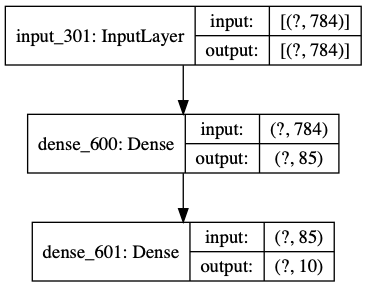

In [15]:
best_model = grid_cv.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

In [16]:
best_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 22us/sample - loss: 0.0987 - accuracy: 0.9739


[0.0986865864562802, 0.9739]

## Further explortion...

Try the following grid parameters:

```python
param_grid = {'n_neurons': range(100,900,100)}
param_grid
```

Were you able to get accuracies over 99 percent? How many epochs are needed to train the model before it starts overfitting?

## Saving the best model

**N.B**: Note that I ran the code three times with a different numbr of nodes each and time with higher test accuracy (~99.6%). 

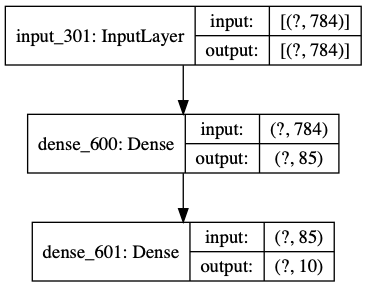

In [17]:
best_model = grid_cv.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

In [18]:
best_model.save("mnist_model_best.h5")

## Evaluating the model

The model with 500 neurons gets a test accuracy of 98%

In [19]:
best_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 21us/sample - loss: 0.0987 - accuracy: 0.9739


[0.0986865864562802, 0.9739]

## Building our network

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

The first `Dense` layer, the hidden layer, consists of `2 nodes`.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))   

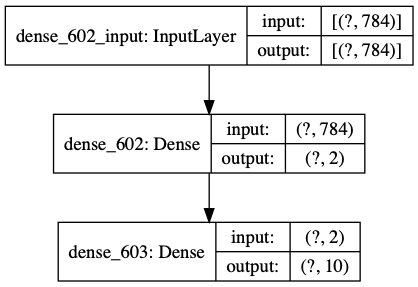

In [21]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [22]:
model.compile(optimizer= 'rmsprop',
#                 loss='categorical_crossentropy',
                loss='sparse_categorical_crossentropy',              
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [23]:
#history = model.fit(train_images, train_labels, epochs=100, batch_size=128)
history = model.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 35us/sample - loss: 1.5607 - accuracy: 0.4210 - val_loss: 1.2323 - val_accuracy: 0.5832
Epoch 2/30
55000/55000 [==============================] - 2s 31us/sample - loss: 1.1712 - accuracy: 0.5889 - val_loss: 1.0935 - val_accuracy: 0.6054
Epoch 3/30
55000/55000 [==============================] - 2s 30us/sample - loss: 1.0889 - accuracy: 0.6208 - val_loss: 1.0353 - val_accuracy: 0.6448
Epoch 4/30
55000/55000 [==============================] - 2s 30us/sample - loss: 1.0518 - accuracy: 0.6363 - val_loss: 1.0114 - val_accuracy: 0.6456
Epoch 5/30
55000/55000 [==============================] - 2s 31us/sample - loss: 1.0307 - accuracy: 0.6442 - val_loss: 0.9971 - val_accuracy: 0.6628
Epoch 6/30
55000/55000 [==============================] - 2s 30us/sample - loss: 1.0170 - accuracy: 0.6513 - val_loss: 0.9906 - val_accuracy: 0.6654
Epoch 7/30
55000/55000 [==============================] -

## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

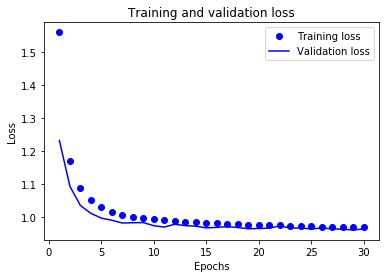

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

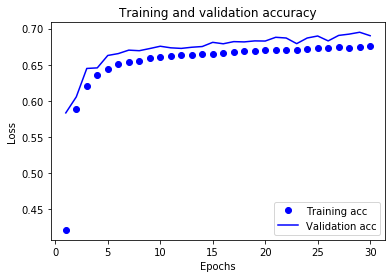

In [26]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Testing the model

Evaluate the model on the test dataset.

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.9804 - accuracy: 0.6798


In [28]:
print('test_acc:', test_acc)  # Not very good...

test_acc: 0.6798


## Confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics` and `tensorflow`. Then we visualize the confusion matrix and see what that tells us.

In [29]:
# Get the predicted classes:
pred_classes = best_model.predict_classes(train_images)

In [30]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5395,    1,    5,    2,    3,    7,    8,    2,    9,   12],
       [   1, 6130,   13,    3,    8,    0,    0,    8,   10,    6],
       [   6,    6, 5424,   11,    6,    0,    2,    6,    4,    5],
       [   1,    0,   30, 5562,    0,   11,    0,    6,   10,   18],
       [   1,    1,    3,    0, 5233,    0,    6,    2,    4,   57],
       [   2,    1,    6,   16,    6, 4900,    9,    1,   18,   28],
       [   6,    5,    5,    0,    6,   13, 5368,    0,   12,    2],
       [   2,    6,   15,    3,   12,    1,    0, 5608,    2,   66],
       [   3,   13,   16,   11,    5,   10,    1,    2, 5308,   20],
       [   3,    2,    1,   10,    7,    6,    1,   10,    2, 5412]])

Looks like there were 66 sevens confused as nones. We see the same thing in the heat map for the error below. 

## Visualizing the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

In [31]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

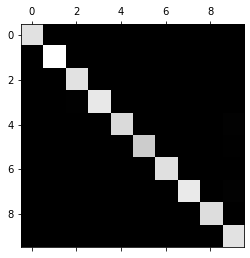

In [32]:
import matplotlib.pyplot as plt

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

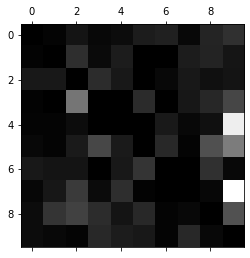

In [34]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [35]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

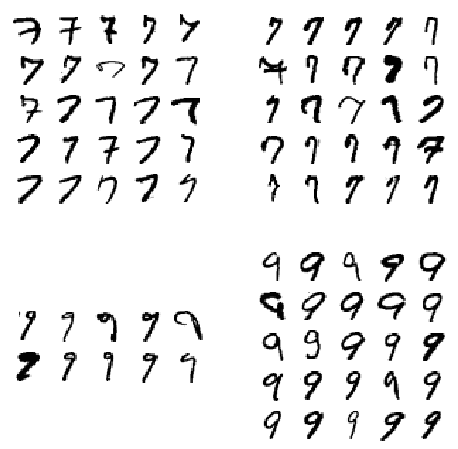

In [36]:
cl_a, cl_b = 7,9
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("error_analysis_digits_plot_EXP1_valid")
plt.show()